In [1]:
import copy
import random

import numpy

from functools import partial

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

print('imports ok')

imports ok


In [2]:
def progn(*args):
    for arg in args:
        arg()

def p2(out1, out2): 
    return partial(progn,out1,out2)

def p3(out1, out2, out3):     
    return partial(progn,out1,out2,out3)

def if_then_else(condition, out1, out2):
    out1() if condition() else out2()

class AntSimulator(object):
    direction = ["north","east","south","west"]
    dir_row = [1, 0, -1, 0]
    dir_col = [0, 1, 0, -1]
    
    def __init__(self, max_moves):
        self.max_moves = max_moves
        self.moves = 0
        self.eaten = 0
        self.routine = None
        
    def _reset(self):
        self.row = self.row_start 
        self.col = self.col_start 
        self.dir = 1
        self.moves = 0  
        self.eaten = 0
        self.matrix_exc = copy.deepcopy(self.matrix)

    @property
    def position(self):
        return (self.row, self.col, self.direction[self.dir])
            
    def left(self): 
        if self.moves < self.max_moves:
            self.moves += 1
            self.dir = (self.dir - 1) % 4

    def right(self):
        if self.moves < self.max_moves:
            self.moves += 1    
            self.dir = (self.dir + 1) % 4
        
    def fd(self):
        if self.moves < self.max_moves:
            self.moves += 1
            self.row = (self.row + self.dir_row[self.dir]) % self.matrix_row
            self.col = (self.col + self.dir_col[self.dir]) % self.matrix_col
            if self.matrix_exc[self.row][self.col] == "food":
                self.eaten += 1
            self.matrix_exc[self.row][self.col] = "passed"

    def sense_food(self):
        ahead_row = (self.row + self.dir_row[self.dir]) % self.matrix_row
        ahead_col = (self.col + self.dir_col[self.dir]) % self.matrix_col        
        return self.matrix_exc[ahead_row][ahead_col] == "food"
   
    def food_fd(self, out1, out2):
        return partial(if_then_else, self.sense_food, out1, out2)
   
    def run(self,routine):
        self._reset()
        while self.moves < self.max_moves:
            routine()
    
    def parse_matrix(self, matrix):
        self.matrix = list()
        for i, line in enumerate(matrix):
            self.matrix.append(list())
            for j, col in enumerate(line):
                if col == "#":
                    self.matrix[-1].append("food")
                elif col == ".":
                    self.matrix[-1].append("empty")
                elif col == "S":
                    self.matrix[-1].append("empty")
                    self.row_start = self.row = i
                    self.col_start = self.col = j
                    self.dir = 1
        self.matrix_row = len(self.matrix)
        self.matrix_col = len(self.matrix[0])
        self.matrix_exc = copy.deepcopy(self.matrix)

print('defs ok')

defs ok


In [3]:
ant = AntSimulator(600)

pset = gp.PrimitiveSet("MAIN", 0)
pset.addPrimitive(ant.food_fd, 2)
pset.addPrimitive(p2, 2)
pset.addPrimitive(p3, 3)
pset.addTerminal(ant.fd) # move_forward
pset.addTerminal(ant.left) # turn_left
pset.addTerminal(ant.right) # turn_right

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("expr_init", gp.genFull, pset=pset, min_=1, max_=2)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalArtificialAnt(individual):
    # Transform the tree expression to functional Python code
    routine = gp.compile(individual, pset)
    # Run the generated routine
    ant.run(routine)
    return ant.eaten,

toolbox.register("evaluate", evalArtificialAnt)
toolbox.register("select", tools.selTournament, tournsize=7)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

print('gp ok')

gp ok


In [4]:
random.seed(69)
    
with open("ant/santafe_trail.txt") as trail_file:
    ant.parse_matrix(trail_file)
    
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)
   
algorithms.eaSimple(pop, toolbox, 0.5, 0.2, 50, stats, halloffame=hof)
    
### print(pop)
### print(hof)
### print(stats)

print('exit ok')

gen	nevals	avg 	std    	min	max
0  	300   	0.28	1.91701	0  	20 
1  	201   	1.62	4.99823	0  	29 
2  	180   	4.52667	7.91471	0  	36 
3  	186   	10.0967	11.0451	0  	56 
4  	174   	17.58  	13.8664	0  	58 
5  	175   	21.65  	17.721 	0  	58 
6  	170   	27.3667	20.5969	0  	58 
7  	183   	32.5067	23.8951	0  	58 
8  	182   	34.6933	25.7701	0  	59 
9  	170   	39.33  	24.7085	0  	59 
10 	190   	36.7367	26.1877	0  	59 
11 	192   	36.4367	26.1521	0  	61 
12 	203   	36.28  	26.7257	0  	62 
13 	197   	36.41  	27.1424	0  	68 
14 	174   	42.5067	25.7878	0  	68 
15 	160   	44.4733	25.6825	0  	68 
16 	184   	45.8733	26.5636	0  	68 
17 	196   	47.44  	26.4909	0  	68 
18 	179   	50.1633	25.4381	0  	68 
19 	175   	49.8   	26.4063	0  	68 
20 	194   	49.6567	26.0721	0  	68 
21 	176   	52.1533	24.4824	0  	68 
22 	165   	50.1567	26.6708	0  	68 
23 	198   	49.0033	26.5145	0  	68 
24 	171   	52.16  	25.0635	0  	68 
25 	198   	49.41  	26.4327	0  	68 
26 	182   	51.1267	26.5166	0  	69 
27 	192   	47.8667	27.892 	0 

In [5]:
bests = tools.selBest(pop, k=1)
print(bests[0])

p3(food_fd(p2(fd, fd), fd), p2(food_fd(p2(food_fd(p2(fd, fd), fd), p3(p3(fd, right, fd), p3(fd, right, fd), p2(fd, left))), food_fd(p2(food_fd(fd, fd), p2(fd, right)), food_fd(p2(food_fd(p2(fd, fd), fd), p3(p3(fd, right, p2(fd, right)), p3(fd, right, fd), p3(food_fd(fd, fd), right, fd))), food_fd(fd, right)))), fd), p3(fd, p3(left, fd, fd), fd))


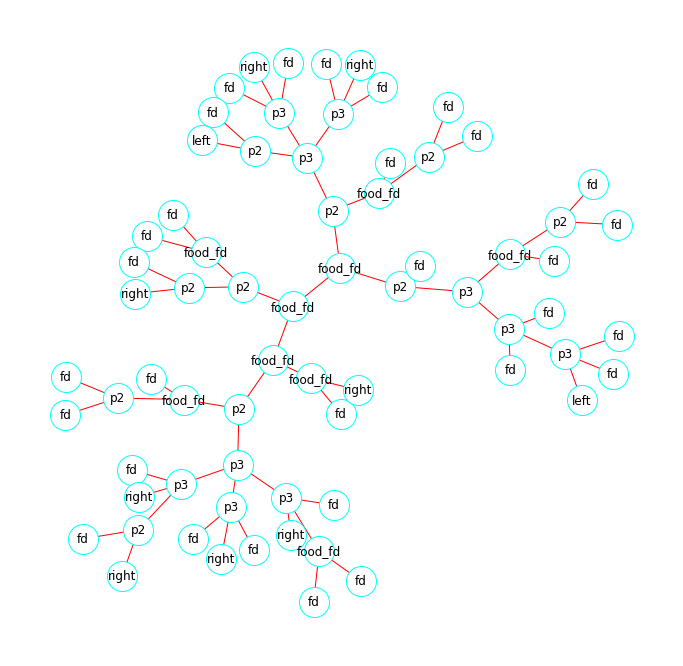

In [6]:
import matplotlib.pyplot as plt
import networkx

nodes, edges, labels = gp.graph(bests[0])
graph = networkx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = networkx.kamada_kawai_layout(graph)

plt.figure(figsize=(12,12))
networkx.draw_networkx_nodes(graph, pos, node_size=900, node_color='white',edgecolors='cyan')
networkx.draw_networkx_edges(graph, pos,edge_color='red')
networkx.draw_networkx_labels(graph, pos, labels)
plt.axis("off")
plt.show()